In [1]:
import numpy as np
import pandas as pd
# import sqlite3 as sql
# import os
import matplotlib.pyplot as plt
import seaborn as sns
# import plotly.graph_objs as go
from xgboost import XGBRegressor
import shap
import pygwalker as pyg

from dotenv import load_dotenv
import sys
sys.path.insert(0, '../data_prep')
from sqlite_utils import select_statement_to_df

c:\Users\tomdevine\Desktop\dev\PersonalProjects\letterboxd-app\letterboxd-env\Lib\site-packages\shap\utils\_clustering.py:34: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
c:\Users\tomdevine\Desktop\dev\PersonalProjects\letterboxd-app\letterboxd-env\Lib\site-packages\shap\utils\_clustering.py:53: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
c:\Users\t

In [2]:
load_dotenv()

True

In [3]:
eligible_watchlist_query = """

WITH BASE_TABLE AS (
    
      SELECT
      
        a.FILM_ID
        ,c.FILM_TITLE
        ,d.FILM_GENRE
        ,e.FILM_RATING
        ,f.FILM_RATING_SCALED
        ,CASE WHEN f.FILM_RATING_SCALED IS NOT NULL THEN 1 ELSE 0 END AS RATED
      
      FROM ALL_FILMS a
      LEFT JOIN CONTENT_TYPE b
      ON a.FILM_ID = b.FILM_ID
      LEFT JOIN FILM_TITLE c
      ON a.FILM_ID = c.FILM_ID
      LEFT JOIN FILM_GENRE d
      ON a.FILM_ID = d.FILM_ID
      LEFT JOIN FILM_LETTERBOXD_STATS e
      ON a.FILM_ID = e.FILM_ID
      LEFT JOIN PERSONAL_RATING f
      ON a.FILM_ID = f.FILM_ID
      
      WHERE CONTENT_TYPE = 'movie'
      
    )
   
    SELECT

      a.FILM_ID
      ,b.FILM_TITLE
      ,b.LETTERBOXD_URL
      ,c.FILM_WATCH_COUNT
      ,c.FILM_TOP_250
      ,c.FILM_RATING
      ,c.FILM_LIKES_COUNT
      ,COALESCE(c.FILM_LIKES_COUNT/c.FILM_WATCH_COUNT, 0.0) AS LIKES_PER_WATCH
      ,c.FILM_FAN_COUNT
      ,COALESCE(c.FILM_FAN_COUNT/c.FILM_WATCH_COUNT, 0.0) AS FANS_PER_WATCH
      ,d.FILM_RUNTIME
      ,f.FILM_DECADE
      ,f.FILM_YEAR
      ,e.ALL_FILM_GENRES
    
    FROM ALL_FEATURE_FILMS a
    LEFT JOIN FILM_TITLE b
    ON a.FILM_ID = b.FILM_ID
    LEFT JOIN FILM_LETTERBOXD_STATS c
    ON a.FILM_ID = c.FILM_ID
    LEFT JOIN FILM_RUNTIME d
    ON a.FILM_ID = d.FILM_ID
    LEFT JOIN FILM_GENRE e
    ON a.FILM_ID = e.FILM_ID
    LEFT JOIN FILM_YEAR f
    ON a.FILM_ID = f.FILM_ID

"""

In [4]:
keyword_query = """

WITH BASE_TABLE AS (
    
    SELECT
    
        a.FILM_ID
        ,c.FILM_TITLE
        ,d.KEYWORD
        ,d.KEYWORD_ID
        ,e.FILM_RATING
        ,f.FILM_RATING_SCALED
        ,CASE WHEN f.FILM_RATING_SCALED IS NOT NULL THEN 1 ELSE 0 END AS RATED
    
    FROM ALL_FEATURE_FILMS a
    LEFT JOIN CONTENT_TYPE b
    ON a.FILM_ID = b.FILM_ID
    LEFT JOIN FILM_TITLE c
    ON a.FILM_ID = c.FILM_ID
    LEFT JOIN FILM_KEYWORDS d
    ON a.FILM_ID = d.FILM_ID
    LEFT JOIN FILM_LETTERBOXD_STATS e
    ON a.FILM_ID = e.FILM_ID
    LEFT JOIN PERSONAL_RATING f
    ON a.FILM_ID = f.FILM_ID
    
    WHERE b.CONTENT_TYPE = 'movie'
    
    )
    
, SCORE_TABLE AS (

    SELECT

    KEYWORD_ID
    ,KEYWORD
    ,AVG(FILM_RATING) AS MEAN_RATING
    ,AVG(FILM_RATING_SCALED) AS MY_MEAN_RATING
    ,AVG(FILM_RATING_SCALED) - AVG(FILM_RATING) AS MY_VARIANCE
    ,((AVG(FILM_RATING_SCALED) - AVG(FILM_RATING)) * ((SUM(RATED)+0.0)/COUNT(*))) AS VARIANCE_SCORE
    ,COUNT(*) AS KEYWORD_COUNT
    ,SUM(RATED) AS MY_RATING_COUNT
    ,(SUM(RATED)+0.0)/COUNT(*) AS SCALER
    
    FROM BASE_TABLE
    
    GROUP BY KEYWORD
    
    HAVING KEYWORD_COUNT >= 30
    AND SCALER >= 0.2
    AND MY_RATING_COUNT >= 3
    --ORDER BY MEAN_RATING DESC
    --ORDER BY KEYWORD_COUNT DESC
    --ORDER BY MY_VARIANCE DESC
    --ORDER BY VARIANCE_SCORE DESC
    --ORDER BY MY_MEAN_RATING DESC
    --ORDER BY VARIANCE_SCORE DESC
)

SELECT
    a.FILM_ID
    ,a.KEYWORD_ID
    ,b.KEYWORD
    
FROM FILM_KEYWORDS a
LEFT JOIN SCORE_TABLE b
ON a.KEYWORD_ID = b.KEYWORD_ID

WHERE b.KEYWORD_ID IS NOT NULL

"""

In [5]:
my_rating_query = """

    SELECT
         FILM_ID
        ,FILM_RATING_SCALED
    FROM PERSONAL_RATING

"""

In [6]:
director_rating_query = """

WITH BASE_TABLE AS (

    SELECT

        a.FILM_ID
        ,d.FILM_TITLE
        ,b.PERSON_ID
        ,e.PERSON_NAME AS DIRECTOR_NAME
        ,CASE WHEN c.FILM_ID IS NULL THEN 0 ELSE 1 END AS WATCHED
        ,f.FILM_RATING_SCALED
        ,CASE WHEN f.FILM_RATING_SCALED IS NULL THEN 0 ELSE 1 END AS RATED

    FROM ALL_FEATURE_FILMS a

    LEFT JOIN FILM_CREW b
    ON a.FILM_ID = b.FILM_ID

    LEFT JOIN WATCHED c
    ON a.FILM_ID = c.FILM_ID

    LEFT JOIN FILM_TITLE d
    ON a.FILM_ID = d.FILM_ID

    LEFT JOIN PERSON_INFO e
    ON b.PERSON_ID = e.PERSON_ID

    LEFT JOIN PERSONAL_RATING f
    ON a.FILM_ID = f.FILM_ID

    WHERE b.JOB = 'Director'
        
    )
      
, DIRECTOR_RATINGS AS (

	SELECT
      
       PERSON_ID
	  ,DIRECTOR_NAME
      ,COUNT(*) AS TOTAL_FILMS
      ,SUM(WATCHED) AS FILMS_WATCHED
      ,AVG(WATCHED) AS PERCENT_WATCHED
      ,AVG(FILM_RATING_SCALED) AS MEAN_RATING
      ,SUM(RATED) AS FILMS_RATED
      ,AVG(RATED) AS PERCENT_RATED
      
    FROM BASE_TABLE
    
    GROUP BY PERSON_ID, DIRECTOR_NAME

    HAVING TOTAL_FILMS >= 3
    AND FILMS_WATCHED > 1
    AND FILMS_RATED > 1
    AND MEAN_RATING NOT NULL
    AND PERCENT_RATED >= .2
    
 	)
, DIRECTOR_WATCH_STATS AS (

	SELECT
      
       PERSON_ID
	  ,DIRECTOR_NAME
      ,COUNT(*) AS TOTAL_FILMS
      ,AVG(WATCHED) AS PERCENT_WATCHED
      
    FROM BASE_TABLE
    
    GROUP BY PERSON_ID, DIRECTOR_NAME
    
 	)

, MEAN_RATING AS ( SELECT AVG(MEAN_RATING)AS MEAN_TOTAL_RATING FROM DIRECTOR_RATINGS )

, FILM_DIRECTOR_LEVEL AS (

	SELECT
		
		 a.FILM_ID
		,a.FILM_TITLE
		,a.PERSON_ID
		,a.DIRECTOR_NAME
		,COALESCE(b.MEAN_RATING, (SELECT MEAN_TOTAL_RATING FROM MEAN_RATING)) AS DIRECTOR_MEAN_RATING
		,COALESCE(c.TOTAL_FILMS, 0) AS DIRECTOR_TOTAL_FILMS
		,COALESCE(c.PERCENT_WATCHED, 0) AS DIRECTOR_PERCENT_WATCHED
		
	 FROM BASE_TABLE a
	 LEFT JOIN DIRECTOR_RATINGS b 
	 ON a.PERSON_ID = b.PERSON_ID
	 LEFT JOIN DIRECTOR_WATCH_STATS c
	 ON a.PERSON_ID = c.PERSON_ID
	 
	 )
	 
SELECT
	
	 FILM_ID
	,AVG(DIRECTOR_MEAN_RATING) AS DIRECTOR_MEAN_RATING
	,AVG(DIRECTOR_TOTAL_FILMS) AS DIRECTOR_TOTAL_FILMS
	,AVG(DIRECTOR_PERCENT_WATCHED) AS DIRECTOR_PERCENT_WATCHED

FROM FILM_DIRECTOR_LEVEL

GROUP BY FILM_ID, FILM_TITLE

"""

In [7]:
eligible_watchlist_df = select_statement_to_df(eligible_watchlist_query)
eligible_watchlist_df.head()

,FILM_ID,FILM_TITLE,LETTERBOXD_URL,FILM_WATCH_COUNT,FILM_TOP_250,FILM_RATING,FILM_LIKES_COUNT,LIKES_PER_WATCH,FILM_FAN_COUNT,FANS_PER_WATCH,FILM_RUNTIME,FILM_DECADE,FILM_YEAR,ALL_FILM_GENRES
0,f_01ZLI,Jumanji,https://boxd.it/1ZLI,701566,NaN,3.57,125647,0.0,611,0.0,104,1990s,1995,fantasy/family/adventure
1,f_01UTC,Fatal Attraction,https://boxd.it/1UTC,83493,NaN,3.41,13180,0.0,98,0.0,119,1980s,1987,drama/thriller
2,f_020E4,Punch-Drunk Love,https://boxd.it/20E4,411414,NaN,3.96,133499,0.0,6804,0.0,96,2000s,2002,drama/thriller/comedy/romance
3,f_01TBi,Altered States,https://boxd.it/1TBi,50793,NaN,3.59,13089,0.0,200,0.0,102,1980s,1980,horror/science-fiction/thriller
4,f_0t4EQ,Death to 2020,https://boxd.it/t4EQ,77786,NaN,2.74,8886,0.0,3,0.0,71,2020s,2020,comedy


In [8]:
director_rating_df = select_statement_to_df(director_rating_query)
director_rating_df.head()

,FILM_ID,DIRECTOR_MEAN_RATING,DIRECTOR_TOTAL_FILMS,DIRECTOR_PERCENT_WATCHED
0,f_0001C,3.502704,7.0,0.142857
1,f_0002q,3.502704,1.0,0.000000
2,f_0009w,3.502704,7.0,0.142857
3,f_000DQ,3.502704,5.0,0.400000
4,f_000IG,3.502704,10.0,0.500000


In [9]:
eligible_watchlist_df2 = eligible_watchlist_df.merge(director_rating_df, how='left', on='FILM_ID')
eligible_watchlist_df2.head()

,FILM_ID,FILM_TITLE,LETTERBOXD_URL,FILM_WATCH_COUNT,FILM_TOP_250,FILM_RATING,FILM_LIKES_COUNT,LIKES_PER_WATCH,FILM_FAN_COUNT,FANS_PER_WATCH,FILM_RUNTIME,FILM_DECADE,FILM_YEAR,ALL_FILM_GENRES,DIRECTOR_MEAN_RATING,DIRECTOR_TOTAL_FILMS,DIRECTOR_PERCENT_WATCHED
0,f_01ZLI,Jumanji,https://boxd.it/1ZLI,701566,NaN,3.57,125647,0.0,611,0.0,104,1990s,1995,fantasy/family/adventure,3.502704,8.0,0.500000
1,f_01UTC,Fatal Attraction,https://boxd.it/1UTC,83493,NaN,3.41,13180,0.0,98,0.0,119,1980s,1987,drama/thriller,3.502704,9.0,0.222222
2,f_020E4,Punch-Drunk Love,https://boxd.it/20E4,411414,NaN,3.96,133499,0.0,6804,0.0,96,2000s,2002,drama/thriller/comedy/romance,4.185771,9.0,1.000000
3,f_01TBi,Altered States,https://boxd.it/1TBi,50793,NaN,3.59,13089,0.0,200,0.0,102,1980s,1980,horror/science-fiction/thriller,3.502704,21.0,0.142857
4,f_0t4EQ,Death to 2020,https://boxd.it/t4EQ,77786,NaN,2.74,8886,0.0,3,0.0,71,2020s,2020,comedy,3.502704,1.0,1.000000


In [10]:
eligible_watchlist_df2 = pd.concat([eligible_watchlist_df2, eligible_watchlist_df2['ALL_FILM_GENRES'].str.get_dummies(sep='/')], axis=1).drop('ALL_FILM_GENRES', axis=1)

In [11]:
keyword_df = select_statement_to_df(keyword_query)
keyword_df['COUNT'] = 1
keyword_df.head()

,FILM_ID,KEYWORD_ID,KEYWORD,COUNT
0,f_0uYDm,180547,marvel cinematic universe (mcu),1
1,f_0pZCY,13031,creature,1
2,f_0BfbQ,180547,marvel cinematic universe (mcu),1
3,f_0BVqI,180547,marvel cinematic universe (mcu),1
4,f_0mIIu,256183,supernatural horror,1


In [12]:
keyword_df_wide = pd.pivot_table(keyword_df, values='COUNT', index=['FILM_ID'], columns=['KEYWORD']).fillna(0).reset_index()
keyword_df_wide

KEYWORD,FILM_ID,alien life-form,android,buddy,creature,curse,cyberpunk,decapitation,demonic possession,disappearance,...,space marine,space opera,supernatural horror,survival horror,video nasty,virus,werewolf,winter,witchcraft,woods
0,f_0009w,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,f_000uu,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,f_000xe,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,f_002Pa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,f_002sK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1643,f_0zTCy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1644,f_0zUWk,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1645,f_0zdfW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1646,f_0zeDq,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
eligible_watchlist_df4 = eligible_watchlist_df2.merge(keyword_df_wide, how='left', on='FILM_ID')

In [14]:
eligible_watchlist_df4['FILM_TOP_250'] = eligible_watchlist_df4['FILM_TOP_250'].fillna(266)
eligible_watchlist_df4['FILM_RATING'] = eligible_watchlist_df4['FILM_RATING'].fillna(2.0)
eligible_watchlist_df5 = eligible_watchlist_df4.fillna(0)

In [15]:
eligible_watchlist_df5

,FILM_ID,FILM_TITLE,LETTERBOXD_URL,FILM_WATCH_COUNT,FILM_TOP_250,FILM_RATING,FILM_LIKES_COUNT,LIKES_PER_WATCH,FILM_FAN_COUNT,FANS_PER_WATCH,...,space marine,space opera,supernatural horror,survival horror,video nasty,virus,werewolf,winter,witchcraft,woods
0,f_01ZLI,Jumanji,https://boxd.it/1ZLI,701566,266.0,3.57,125647,0.0,611,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,f_01UTC,Fatal Attraction,https://boxd.it/1UTC,83493,266.0,3.41,13180,0.0,98,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,f_020E4,Punch-Drunk Love,https://boxd.it/20E4,411414,266.0,3.96,133499,0.0,6804,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,f_01TBi,Altered States,https://boxd.it/1TBi,50793,266.0,3.59,13089,0.0,200,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,f_0t4EQ,Death to 2020,https://boxd.it/t4EQ,77786,266.0,2.74,8886,0.0,3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10727,f_02qMe,Last Woman on Earth,https://boxd.it/2qMe,1342,266.0,2.76,135,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10728,f_03nmO,Teenage Cave Man,https://boxd.it/3nmO,1316,266.0,2.66,123,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10729,f_032z8,Rock All Night,https://boxd.it/32z8,594,266.0,3.25,152,0.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10730,f_032yO,The Saga of the Viking Women and Their Voyage ...,https://boxd.it/32yO,1182,266.0,2.66,102,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
my_rating_df = select_statement_to_df(my_rating_query)
my_rating_df

,FILM_ID,FILM_RATING_SCALED
0,f_006YA,4.626543
1,f_006YK,4.923077
2,f_0070G,4.839744
3,f_0071a,4.719136
4,f_0071k,4.016187
...,...,...
825,f_0w4Zg,2.994444
826,f_0waRi,3.233333
827,f_0xjfE,2.098837
828,f_0yohi,3.609606


In [17]:
rating_features_df = eligible_watchlist_df5.merge(my_rating_df, how='left', on='FILM_ID')
rating_features_df = rating_features_df.drop(['LETTERBOXD_URL', 'STREAMING', 'STREAMING_SERVICES', 'RENTABLE', 'WATCHABLE', 'MIN_RENTAL_PRICE', 'FILM_DECADE'], axis=1)
rating_features_df

KeyError: "['STREAMING', 'STREAMING_SERVICES', 'RENTABLE', 'WATCHABLE', 'MIN_RENTAL_PRICE'] not found in axis"

In [ ]:
rating_features_df.columns

Index(['FILM_ID', 'FILM_TITLE', 'FILM_WATCH_COUNT', 'FILM_TOP_250',
       'FILM_RATING', 'FILM_LIKES_COUNT', 'FILM_FAN_COUNT', 'FILM_RUNTIME',
       'FILM_YEAR', 'GENRE_SCORE', 'DIRECTOR_MEAN_RATING',
       'DIRECTOR_TOTAL_FILMS', 'DIRECTOR_PERCENT_WATCHED', 'action',
       'adventure', 'animation', 'comedy', 'crime', 'drama', 'family',
       'fantasy', 'history', 'horror', 'mystery', 'none', 'romance',
       'science-fiction', 'thriller', 'war', 'western', 'alien life-form',
       'android', 'anti hero', 'cannibal', 'creature', 'curse', 'cyberpunk',
       'decapitation', 'demonic possession', 'disappearance', 'evil',
       'falling in love', 'folk horror', 'gas station', 'gothic', 'halloween',
       'haunting', 'immortality', 'maniac', 'mansion', 'mask', 'new jersey',
       'nurse', 'psychological thriller', 'rivalry', 'sadism', 'school',
       'series of murders', 'slasher', 'space marine', 'space opera',
       'supernatural horror', 'survival horror', 'teenager', 'trans

In [ ]:
# pyg.walk(rating_features_df)

In [18]:
rated_features = rating_features_df[rating_features_df['FILM_RATING_SCALED'].notnull()].reset_index(drop=True)
rated_features

,FILM_ID,FILM_TITLE,LETTERBOXD_URL,FILM_WATCH_COUNT,FILM_TOP_250,FILM_RATING,FILM_LIKES_COUNT,LIKES_PER_WATCH,FILM_FAN_COUNT,FANS_PER_WATCH,...,space opera,supernatural horror,survival horror,video nasty,virus,werewolf,winter,witchcraft,woods,FILM_RATING_SCALED
0,f_01ZLI,Jumanji,https://boxd.it/1ZLI,701566,266.0,3.57,125647,0.0,611,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.553571
1,f_01UTC,Fatal Attraction,https://boxd.it/1UTC,83493,266.0,3.41,13180,0.0,98,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.821942
2,f_020E4,Punch-Drunk Love,https://boxd.it/20E4,411414,266.0,3.96,133499,0.0,6804,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.113889
3,f_01TBi,Altered States,https://boxd.it/1TBi,50793,266.0,3.59,13089,0.0,200,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.102518
4,f_0099A,The Skin I Live In,https://boxd.it/99A,231526,266.0,3.84,57781,0.0,1179,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.947222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
817,f_01qme,Blood and Black Lace,https://boxd.it/1qme,39067,266.0,3.72,12083,0.0,131,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.785971
818,f_0npL2,Knock at the Cabin,https://boxd.it/npL2,255943,266.0,2.94,50777,0.0,58,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.525862
819,f_0nlQC,Titane,https://boxd.it/nlQC,298214,266.0,3.67,84358,0.0,2820,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.241667
820,f_01U16,Blood Simple,https://boxd.it/1U16,143171,266.0,3.91,40356,0.0,328,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.629310


In [19]:
unrated_features = rating_features_df[rating_features_df['FILM_RATING_SCALED'].isnull()].reset_index(drop=True)
unrated_features

,FILM_ID,FILM_TITLE,LETTERBOXD_URL,FILM_WATCH_COUNT,FILM_TOP_250,FILM_RATING,FILM_LIKES_COUNT,LIKES_PER_WATCH,FILM_FAN_COUNT,FANS_PER_WATCH,...,space opera,supernatural horror,survival horror,video nasty,virus,werewolf,winter,witchcraft,woods,FILM_RATING_SCALED
0,f_0t4EQ,Death to 2020,https://boxd.it/t4EQ,77786,266.0,2.74,8886,0.0,3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,f_02aNK,The Godfather,https://boxd.it/2aNK,1400909,6.0,4.54,555741,0.0,44323,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,f_02aNq,The Godfather: Part II,https://boxd.it/2aNq,785419,5.0,4.54,279663,0.0,17164,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,f_02axi,Seven Samurai,https://boxd.it/2axi,284104,9.0,4.51,107662,0.0,7437,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,f_0azpY,Spider-Man: Into the Spider-Verse,https://boxd.it/azpY,2112250,16.0,4.44,1090676,0.0,59458,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9905,f_02qMe,Last Woman on Earth,https://boxd.it/2qMe,1342,266.0,2.76,135,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
9906,f_03nmO,Teenage Cave Man,https://boxd.it/3nmO,1316,266.0,2.66,123,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
9907,f_032z8,Rock All Night,https://boxd.it/32z8,594,266.0,3.25,152,0.0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
9908,f_032yO,The Saga of the Viking Women and Their Voyage ...,https://boxd.it/32yO,1182,266.0,2.66,102,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [27]:
non_features = ['FILM_ID',
                'FILM_TITLE',
                'FILM_RATING_SCALED',
                'FILM_TOP_250',
                'FILM_RUNTIME',
                'FILM_WATCH_COUNT',
                'LETTERBOXD_URL',
                'FILM_DECADE'
                ]


model_features = [x for x in unrated_features.columns if x not in non_features]

In [29]:
delete_cols = []
for col in model_features:
    col_mean = rated_features[col].mean()
    if col_mean <= .01:
        delete_cols.append(col)
model_features = [x for x in model_features if x not in delete_cols]

In [30]:
target = ['FILM_RATING_SCALED']

In [31]:
X_train = rated_features[model_features]
y_train = rated_features[target]

In [32]:
X_train.columns

Index(['FILM_RATING', 'FILM_LIKES_COUNT', 'FILM_FAN_COUNT', 'FILM_YEAR',
       'DIRECTOR_MEAN_RATING', 'DIRECTOR_TOTAL_FILMS',
       'DIRECTOR_PERCENT_WATCHED', 'action', 'adventure', 'animation',
       'comedy', 'crime', 'drama', 'family', 'fantasy', 'history', 'horror',
       'music', 'mystery', 'romance', 'science-fiction', 'thriller',
       'alien life-form', 'android', 'creature', 'curse', 'cyberpunk',
       'decapitation', 'demonic possession', 'disappearance', 'evil',
       'folk horror', 'gothic', 'halloween', 'haunting', 'immortality',
       'maniac', 'mask', 'new jersey', 'nurse', 'princess',
       'psychological thriller', 'rivalry', 'sadism', 'series of murders',
       'space marine', 'space opera', 'supernatural horror', 'survival horror',
       'video nasty', 'virus', 'werewolf', 'winter', 'woods'],
      dtype='object')

In [33]:
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

<Axes: >

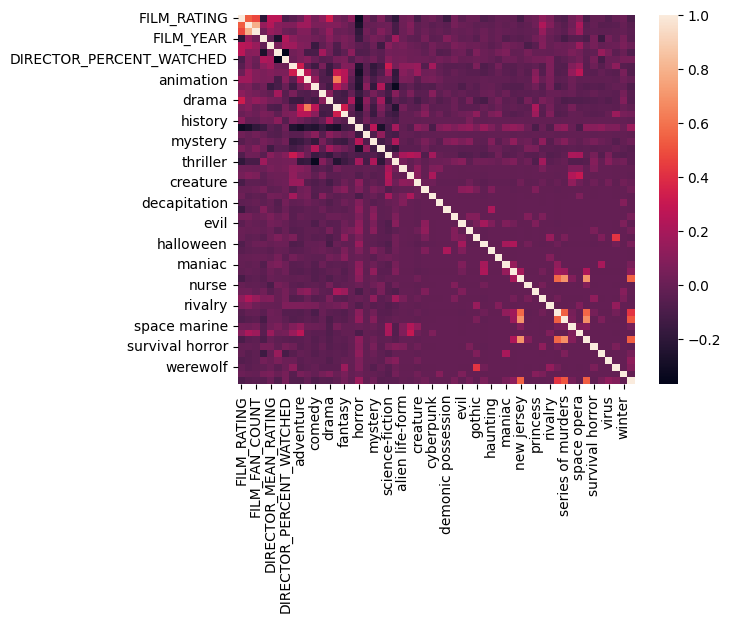

In [34]:
sns.heatmap(X_train.corr())

In [35]:
X_pred = unrated_features[model_features]
pred_df = unrated_features.copy()
pred_df['PREDICTED_SCORE'] = xgb_model.predict(X_pred)
pred_df[pred_df['DIRECTOR_MEAN_RATING'] != pred_df.loc[0, 'DIRECTOR_MEAN_RATING']].sort_values('PREDICTED_SCORE', ascending=False).head(50)
pred_df.sort_values('PREDICTED_SCORE', ascending=False).head(20)

,FILM_ID,FILM_TITLE,LETTERBOXD_URL,FILM_WATCH_COUNT,FILM_TOP_250,FILM_RATING,FILM_LIKES_COUNT,LIKES_PER_WATCH,FILM_FAN_COUNT,FANS_PER_WATCH,...,supernatural horror,survival horror,video nasty,virus,werewolf,winter,witchcraft,woods,FILM_RATING_SCALED,PREDICTED_SCORE
109,f_04VZ8,Interstellar,https://boxd.it/4VZ8,2151537,82.0,4.30,934789,0.0,103265,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,4.976200
123,f_0b8wK,Blade Runner 2049,https://boxd.it/b8wK,1194505,266.0,4.10,454650,0.0,31984,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,4.975677
3,f_02axi,Seven Samurai,https://boxd.it/2axi,284104,9.0,4.51,107662,0.0,7437,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,4.962893
1357,f_01TSo,Memories of Murder,https://boxd.it/1TSo,377290,70.0,4.31,145748,0.0,10923,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,4.952158
347,f_09X0m,The Witch,https://boxd.it/9X0m,908706,266.0,3.87,304606,0.0,9742,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,4.951635
1283,f_00Msm,Incendies,https://boxd.it/Msm,184866,56.0,4.38,66182,0.0,4329,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,4.885002
42,f_01skk,Inception,https://boxd.it/1skk,2371585,225.0,4.18,958477,0.0,41066,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,4.880763
32,f_028yI,Raging Bull,https://boxd.it/28yI,365544,224.0,4.18,110869,0.0,3577,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,4.859475
1294,f_029b6,Paths of Glory,https://boxd.it/29b6,197873,27.0,4.45,67872,0.0,1495,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,4.843738
18,f_025A2,Barry Lyndon,https://boxd.it/25A2,217660,86.0,4.29,74293,0.0,6026,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,4.813788


In [36]:
pred = xgb_model.predict(X_pred, output_margin=True)
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_pred)
# shap_interaction_values = explainer.shap_interaction_values(X_pred)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


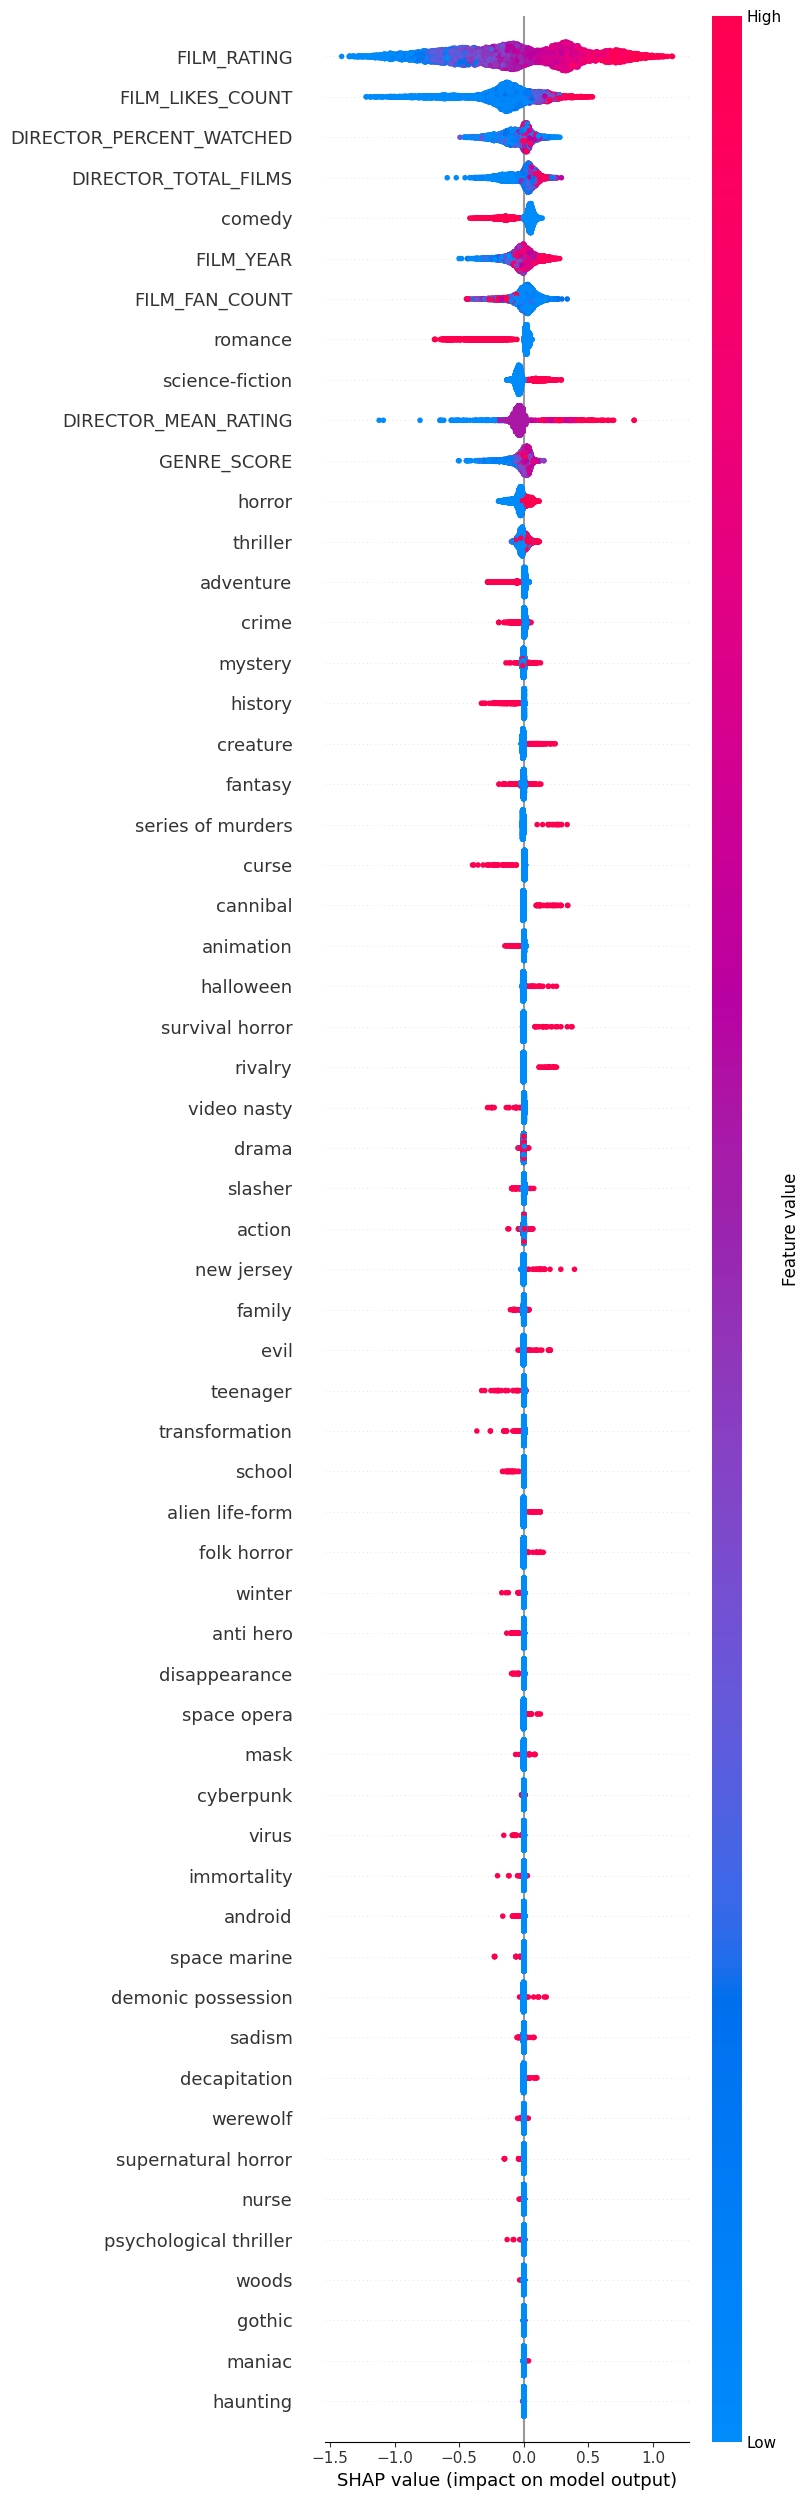

In [359]:
shap.summary_plot(shap_values, X_pred, max_display=X_pred.shape[1])

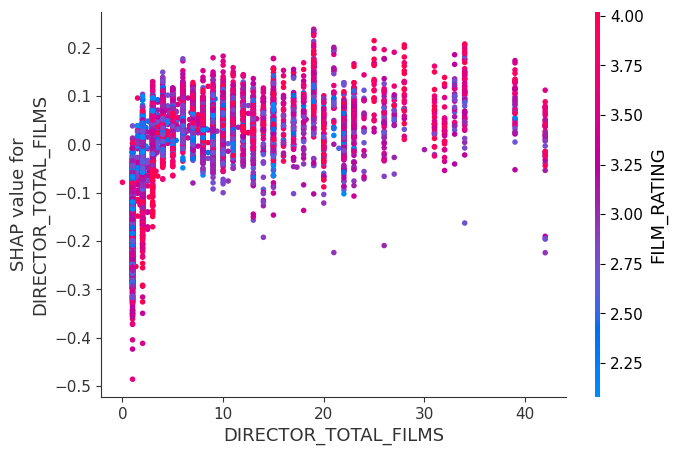

In [37]:
shap.dependence_plot('DIRECTOR_TOTAL_FILMS', shap_values, X_pred, interaction_index='FILM_RATING')

In [38]:
shap.initjs()

In [39]:
film_index = 122
shap.force_plot(explainer.expected_value, shap_values[film_index, :], X_pred.iloc[film_index, :])

In [40]:
pred_df.sort_values('PREDICTED_SCORE', ascending=False).head(10)

,FILM_ID,FILM_TITLE,LETTERBOXD_URL,FILM_WATCH_COUNT,FILM_TOP_250,FILM_RATING,FILM_LIKES_COUNT,LIKES_PER_WATCH,FILM_FAN_COUNT,FANS_PER_WATCH,...,supernatural horror,survival horror,video nasty,virus,werewolf,winter,witchcraft,woods,FILM_RATING_SCALED,PREDICTED_SCORE
109,f_04VZ8,Interstellar,https://boxd.it/4VZ8,2151537,82.0,4.30,934789,0.0,103265,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,4.976200
123,f_0b8wK,Blade Runner 2049,https://boxd.it/b8wK,1194505,266.0,4.10,454650,0.0,31984,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,4.975677
3,f_02axi,Seven Samurai,https://boxd.it/2axi,284104,9.0,4.51,107662,0.0,7437,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,4.962893
1357,f_01TSo,Memories of Murder,https://boxd.it/1TSo,377290,70.0,4.31,145748,0.0,10923,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,4.952158
347,f_09X0m,The Witch,https://boxd.it/9X0m,908706,266.0,3.87,304606,0.0,9742,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,4.951635
1283,f_00Msm,Incendies,https://boxd.it/Msm,184866,56.0,4.38,66182,0.0,4329,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,4.885002
42,f_01skk,Inception,https://boxd.it/1skk,2371585,225.0,4.18,958477,0.0,41066,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,4.880763
32,f_028yI,Raging Bull,https://boxd.it/28yI,365544,224.0,4.18,110869,0.0,3577,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,4.859475
1294,f_029b6,Paths of Glory,https://boxd.it/29b6,197873,27.0,4.45,67872,0.0,1495,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,4.843738
18,f_025A2,Barry Lyndon,https://boxd.it/25A2,217660,86.0,4.29,74293,0.0,6026,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,4.813788


In [41]:
def scale_col(df, column, suffix='', a=0, b=1):
    col_min = df[column].min()
    col_max = df[column].max()
    col_range = (col_max - col_min)
    df[column+suffix] = ((df[column] - col_min) / col_range) * (b - a) + a
    return df

In [42]:
output_df = pred_df.copy()[['FILM_ID', 'PREDICTED_SCORE']]
output_df

,FILM_ID,PREDICTED_SCORE
0,f_0t4EQ,2.606277
1,f_02aNK,3.955021
2,f_02aNq,4.104087
3,f_02axi,4.962893
4,f_0azpY,4.064088
...,...,...
9905,f_02qMe,1.895393
9906,f_03nmO,2.597409
9907,f_032z8,1.715655
9908,f_032yO,1.915452


In [43]:
output_df[output_df['FILM_ID'] == 'f_01KqU']

,FILM_ID,PREDICTED_SCORE


In [44]:
output_df = scale_col(output_df, 'PREDICTED_SCORE')
output_df.sort_values('PREDICTED_SCORE', ascending=False)

,FILM_ID,PREDICTED_SCORE
109,f_04VZ8,1.000000
123,f_0b8wK,0.999895
3,f_02axi,0.997333
1357,f_01TSo,0.995182
347,f_09X0m,0.995077
...,...,...
7080,f_01C1C,0.057445
9127,f_07sUu,0.049642
8078,f_04WMu,0.048528
9049,f_01pCU,0.037841


In [45]:
explainer_df = pd.DataFrame(shap_values, columns=X_pred.columns)
explainer_df.insert(0, 'FILM_ID', pred_df['FILM_ID'])
explainer_df.insert(1, 'BASE_VALUE', explainer.expected_value)
explainer_df['PREDICTION'] = explainer_df.sum(axis=1)
explainer_df = explainer_df.merge(output_df, how='left', on='FILM_ID')
explainer_df['SCALER'] = explainer_df['PREDICTED_SCORE'] / explainer_df['PREDICTION']
explainer_df

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


,FILM_ID,BASE_VALUE,FILM_RATING,FILM_LIKES_COUNT,FILM_FAN_COUNT,FILM_YEAR,DIRECTOR_MEAN_RATING,DIRECTOR_TOTAL_FILMS,DIRECTOR_PERCENT_WATCHED,action,...,supernatural horror,survival horror,video nasty,virus,werewolf,winter,woods,PREDICTION,PREDICTED_SCORE,SCALER
0,f_0t4EQ,3.304425,-0.474775,-0.145581,0.013576,0.287720,-0.057305,-0.065760,0.037427,0.006507,...,0.000066,-0.000657,0.001817,0.000344,0.000204,0.007471,-0.000066,2.606277,0.525024,0.201446
1,f_02aNK,3.304425,1.006313,0.159174,-0.141721,-0.089194,-0.015063,0.047694,-0.167265,-0.000855,...,0.000069,-0.000024,0.000245,-0.000307,0.000197,0.000802,-0.000071,3.955019,0.795337,0.201096
2,f_02aNq,3.304425,1.133224,0.159644,-0.122035,-0.088549,-0.018861,0.053999,-0.159927,-0.000794,...,0.000069,-0.000024,0.000245,-0.000307,0.000197,0.000802,-0.000071,4.104086,0.825213,0.201071
3,f_02axi,3.304425,1.170070,0.345243,0.043943,-0.087723,0.008935,0.127985,0.036514,-0.008449,...,0.000041,0.000403,-0.000005,-0.000312,0.000192,0.000799,-0.000148,4.962892,0.997333,0.200958
4,f_0azpY,3.304425,0.853153,0.299252,-0.133240,0.067343,-0.022058,-0.252742,0.006443,0.001206,...,0.000024,0.001221,0.000242,0.000389,0.000181,0.002879,-0.000163,4.064088,0.817196,0.201077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9905,f_02qMe,3.304425,-0.701526,-0.218197,-0.151861,-0.141145,-0.028507,0.040219,0.015728,-0.001311,...,0.000055,0.000406,0.000967,0.003252,0.000203,0.000980,-0.000071,1.895395,0.382550,0.201831
9906,f_03nmO,3.304425,-0.627464,-0.320775,-0.128172,-0.202250,-0.014821,0.100451,0.123114,-0.000516,...,0.000055,0.000327,0.000967,0.002903,0.000203,0.001167,-0.000071,2.597409,0.523247,0.201450
9907,f_032z8,3.304425,-0.444339,-0.455617,-0.147417,-0.236697,-0.025779,0.099874,0.082099,-0.001637,...,0.000041,-0.002880,0.000388,-0.000349,0.000223,0.001640,-0.000071,1.715657,0.346527,0.201979
9908,f_032yO,3.304425,-0.670063,-0.446740,-0.136995,-0.229098,-0.021792,0.118956,0.105464,-0.001579,...,0.000055,-0.000709,0.000923,0.000362,0.000222,0.001119,-0.000071,1.915454,0.386570,0.201817


In [46]:
explainer_df2 = explainer_df.drop('FILM_ID', axis=1).mul(explainer_df['SCALER'], axis=0).drop(['PREDICTED_SCORE', 'SCALER'], axis=1)
explainer_df2.insert(0, 'FILM_ID', pred_df['FILM_ID'])
explainer_df2

,FILM_ID,BASE_VALUE,FILM_RATING,FILM_LIKES_COUNT,FILM_FAN_COUNT,FILM_YEAR,DIRECTOR_MEAN_RATING,DIRECTOR_TOTAL_FILMS,DIRECTOR_PERCENT_WATCHED,action,...,space marine,space opera,supernatural horror,survival horror,video nasty,virus,werewolf,winter,woods,PREDICTION
0,f_0t4EQ,0.665663,-0.095642,-0.029327,0.002735,0.057960,-0.011544,-0.013247,0.007540,0.001311,...,-0.000094,-0.000294,0.000013,-0.000132,3.660827e-04,0.000069,0.000041,0.001505,-0.000013,0.525024
1,f_02aNK,0.664506,0.202365,0.032009,-0.028499,-0.017937,-0.003029,0.009591,-0.033636,-0.000172,...,0.000025,-0.000771,0.000014,-0.000005,4.932767e-05,-0.000062,0.000040,0.000161,-0.000014,0.795337
2,f_02aNq,0.664424,0.227858,0.032100,-0.024538,-0.017805,-0.003792,0.010858,-0.032157,-0.000160,...,0.000025,-0.000840,0.000014,-0.000005,4.932162e-05,-0.000062,0.000040,0.000161,-0.000014,0.825213
3,f_02axi,0.664051,0.235135,0.069379,0.008831,-0.017629,0.001796,0.025720,0.007338,-0.001698,...,0.000031,-0.000807,0.000008,0.000081,-9.766691e-07,-0.000063,0.000039,0.000160,-0.000030,0.997333
4,f_0azpY,0.664445,0.171550,0.060173,-0.026792,0.013541,-0.004435,-0.050821,0.001295,0.000243,...,0.000110,-0.000853,0.000005,0.000245,4.862730e-05,0.000078,0.000036,0.000579,-0.000033,0.817196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9905,f_02qMe,0.666937,-0.141590,-0.044039,-0.030650,-0.028488,-0.005754,0.008118,0.003174,-0.000265,...,-0.000034,-0.000383,0.000011,0.000082,1.951691e-04,0.000656,0.000041,0.000198,-0.000014,0.382550
9906,f_03nmO,0.665675,-0.126402,-0.064620,-0.025820,-0.040743,-0.002986,0.020236,0.024801,-0.000104,...,0.000147,-0.000382,0.000011,0.000066,1.947999e-04,0.000585,0.000041,0.000235,-0.000014,0.523247
9907,f_032z8,0.667426,-0.089747,-0.092025,-0.029775,-0.047808,-0.005207,0.020172,0.016582,-0.000331,...,-0.000049,-0.000452,0.000008,-0.000582,7.844709e-05,-0.000070,0.000045,0.000331,-0.000014,0.346527
9908,f_032yO,0.666888,-0.135230,-0.090160,-0.027648,-0.046236,-0.004398,0.024007,0.021284,-0.000319,...,0.000135,-0.000383,0.000011,-0.000143,1.863631e-04,0.000073,0.000045,0.000226,-0.000014,0.386570


In [47]:
explainer_df2.head(1).drop('PREDICTION', axis=1)

,FILM_ID,BASE_VALUE,FILM_RATING,FILM_LIKES_COUNT,FILM_FAN_COUNT,FILM_YEAR,DIRECTOR_MEAN_RATING,DIRECTOR_TOTAL_FILMS,DIRECTOR_PERCENT_WATCHED,action,...,series of murders,space marine,space opera,supernatural horror,survival horror,video nasty,virus,werewolf,winter,woods
0,f_0t4EQ,0.665663,-0.095642,-0.029327,0.002735,0.05796,-0.011544,-0.013247,0.00754,0.001311,...,-0.001127,-0.000094,-0.000294,0.000013,-0.000132,0.000366,0.000069,0.000041,0.001505,-0.000013


In [48]:
melted_df = pd.melt(explainer_df2.head(1).drop('PREDICTION', axis=1), id_vars=["FILM_ID"])
valid_melted_df = melted_df[melted_df['value'].abs() > 0.01].reset_index(drop=True)
valid_melted_df

,FILM_ID,variable,value
0,f_0t4EQ,BASE_VALUE,0.665663
1,f_0t4EQ,FILM_RATING,-0.095642
2,f_0t4EQ,FILM_LIKES_COUNT,-0.029327
3,f_0t4EQ,FILM_YEAR,0.057960
4,f_0t4EQ,DIRECTOR_MEAN_RATING,-0.011544
5,f_0t4EQ,DIRECTOR_TOTAL_FILMS,-0.013247
6,f_0t4EQ,comedy,-0.028151
7,f_0t4EQ,horror,-0.016522
8,f_0t4EQ,science-fiction,-0.013998


In [49]:
valid_melted_df['og_val'] = valid_melted_df.apply(lambda x: pred_df[pred_df['FILM_ID']==x.FILM_ID].loc[:, x['variable']].values[0] if x['variable'] != 'BASE_VALUE' else None, axis=1)
valid_melted_df

,FILM_ID,variable,value,og_val
0,f_0t4EQ,BASE_VALUE,0.665663,NaN
1,f_0t4EQ,FILM_RATING,-0.095642,2.740000
2,f_0t4EQ,FILM_LIKES_COUNT,-0.029327,8886.000000
3,f_0t4EQ,FILM_YEAR,0.057960,2020.000000
4,f_0t4EQ,DIRECTOR_MEAN_RATING,-0.011544,3.502704
5,f_0t4EQ,DIRECTOR_TOTAL_FILMS,-0.013247,1.000000
6,f_0t4EQ,comedy,-0.028151,1.000000
7,f_0t4EQ,horror,-0.016522,0.000000
8,f_0t4EQ,science-fiction,-0.013998,0.000000


In [50]:
valid_melted_df['label'] = np.where(valid_melted_df['variable'] == 'BASE_VALUE', 'BASE_VALUE', valid_melted_df['variable'].astype('str') + '=' + valid_melted_df['og_val'].astype('str'))

In [51]:
valid_melted_df

,FILM_ID,variable,value,og_val,label
0,f_0t4EQ,BASE_VALUE,0.665663,NaN,BASE_VALUE
1,f_0t4EQ,FILM_RATING,-0.095642,2.740000,FILM_RATING=2.74
2,f_0t4EQ,FILM_LIKES_COUNT,-0.029327,8886.000000,FILM_LIKES_COUNT=8886.0
3,f_0t4EQ,FILM_YEAR,0.057960,2020.000000,FILM_YEAR=2020.0
4,f_0t4EQ,DIRECTOR_MEAN_RATING,-0.011544,3.502704,DIRECTOR_MEAN_RATING=3.502703580244703
5,f_0t4EQ,DIRECTOR_TOTAL_FILMS,-0.013247,1.000000,DIRECTOR_TOTAL_FILMS=1.0
6,f_0t4EQ,comedy,-0.028151,1.000000,comedy=1.0
7,f_0t4EQ,horror,-0.016522,0.000000,horror=0.0
8,f_0t4EQ,science-fiction,-0.013998,0.000000,science-fiction=0.0


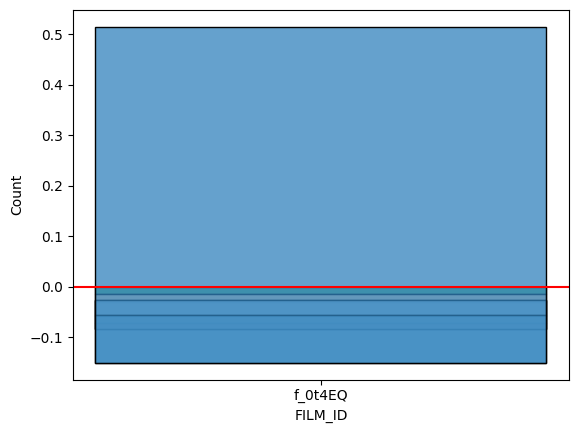

In [52]:
sns.histplot(valid_melted_df, x='FILM_ID', hue='label', weights='value', multiple='stack', palette='tab20c', legend=False)
plt.axhline(0, color='red')

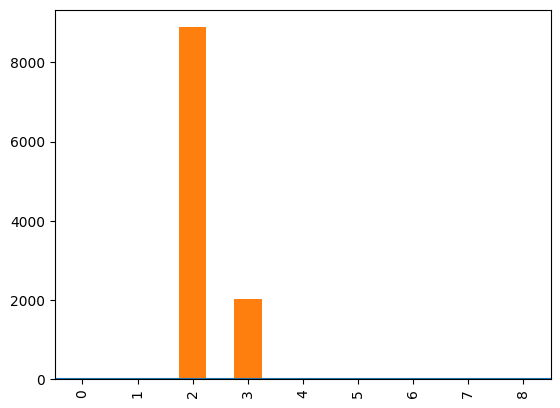

In [53]:
# valid_melted_df.pivot_table(values='value', index='FILM_ID', columns='variable').reset_index().plot(kind='bar', stacked=True, legend=None)
valid_melted_df.plot(kind='bar', stacked=True, legend=None)
plt.axhline(0)


In [54]:
valid_melted_df_pos = valid_melted_df[valid_melted_df['value']>0]
valid_melted_df_neg = valid_melted_df[valid_melted_df['value']<0]

<Axes: >

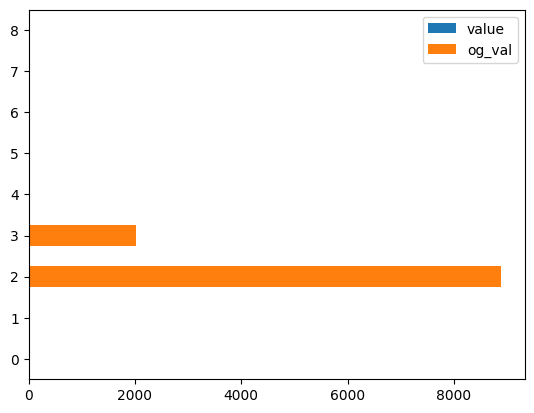

In [55]:
valid_melted_df.plot(kind='barh', stacked=True)

<Axes: xlabel='FILM_ID', ylabel='Count'>

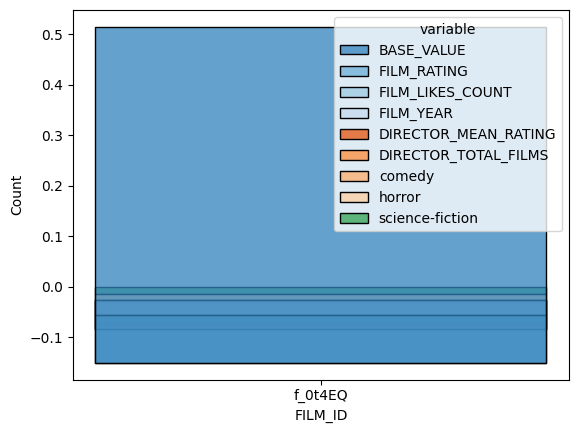

In [56]:
sns.histplot(melted_df[melted_df['value'].abs() > 0.01], x='FILM_ID', hue='variable', weights='value',
             multiple='stack', palette='tab20c')

<Axes: xlabel='value', ylabel='FILM_ID'>

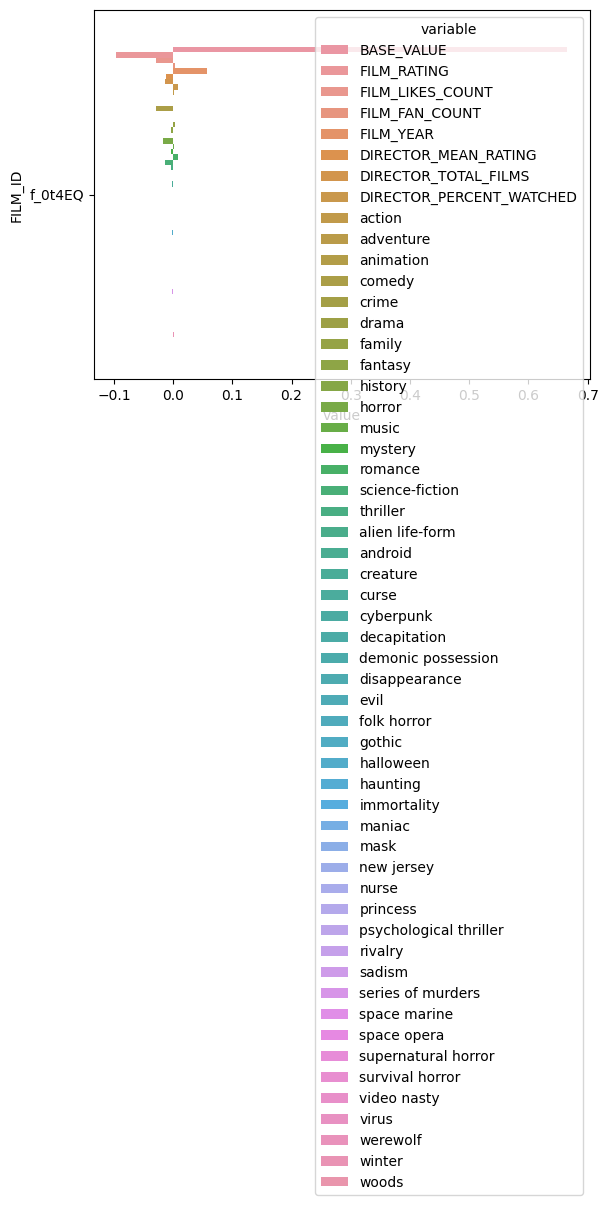

In [57]:
sns.barplot(melted_df, x='value', y='FILM_ID', hue='variable')

<Axes: >

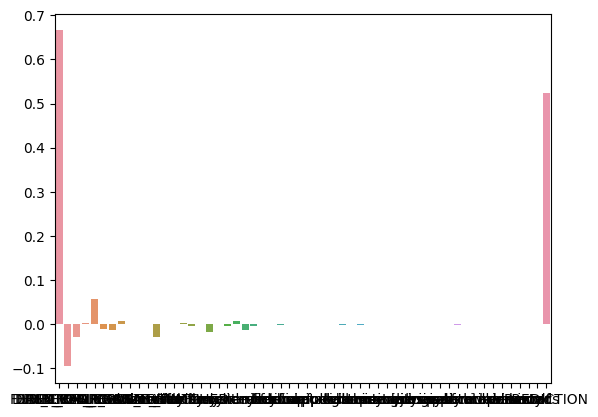

In [58]:
sns.barplot(explainer_df2.head(1))

In [59]:
df_scaled = df.copy()
df_scaled['FILM_TOP_250'] = np.where(df_scaled['FILM_TOP_250'].notnull(), 1, 0)
df_scaled['FILM_RUNTIME'] = 1 / df_scaled['FILM_RUNTIME']
df_scaled['FILM_RATING'] = df_scaled['FILM_RATING'].fillna(df_scaled['FILM_RATING'].mean())
df_scaled['SEEN_SCORE'] = np.where(df_scaled['SEEN']==1, 0, 1)
df_scaled = scale_col(df_scaled, 'FILM_WATCH_COUNT')
df_scaled = scale_col(df_scaled, 'FILM_RATING')
df_scaled = scale_col(df_scaled, 'FILM_LIKES_COUNT')
df_scaled = scale_col(df_scaled, 'FILM_FAN_COUNT')
df_scaled = scale_col(df_scaled, 'FILM_RUNTIME')
df_scaled = scale_col(df_scaled, 'GENRE_SCORE')
df_scaled.sort_values('FILM_TOP_250')

NameError: name 'df' is not defined

In [60]:
df_scaled['SCORE_BASIC'] =                         \
      df_scaled['SEEN_SCORE']       * 1      \
    + df_scaled['FILM_WATCH_COUNT'] * 1      \
    + df_scaled['FILM_TOP_250']     * 1      \
    + df_scaled['FILM_RATING']      * 1      \
    + df_scaled['FILM_FAN_COUNT']   * 1      \
    + df_scaled['FILM_RUNTIME']     * 1      \
    + df_scaled['GENRE_SCORE']      * 1      \
    
df_scaled = scale_col(df_scaled, 'SCORE_BASIC', a=0, b=100)

NameError: name 'df_scaled' is not defined

In [106]:
df_scaled['SCORE_WEIGHTED'] =                \
      df_scaled['SEEN_SCORE']       * 3      \
    + df_scaled['FILM_WATCH_COUNT'] * 2      \
    + df_scaled['FILM_TOP_250']     * 1      \
    + df_scaled['FILM_RATING']      * 2      \
    + df_scaled['FILM_FAN_COUNT']   * 1      \
    + df_scaled['FILM_RUNTIME']     * 2      \
    + df_scaled['GENRE_SCORE']      * 2      \
    
df_scaled = scale_col(df_scaled, 'SCORE_WEIGHTED', a=0, b=100)
df_scaled.sort_values('SCORE_WEIGHTED', ascending=False).head(10)

,FILM_ID,FILM_TITLE,SEEN,FILM_WATCH_COUNT,FILM_TOP_250,FILM_RATING,FILM_LIKES_COUNT,FILM_FAN_COUNT,STREAMING,FILM_RUNTIME,FILM_GENRE,GENRE_SCORE,SEEN_SCORE,SCORE_BASIC,SCORE_WEIGHTED
603,f_029DO,The Passion of Joan of Arc,0,0.044619,1,0.975976,0.033144,0.016555,Yes,0.636455,history,0.595843,1,83.551767,100.000000
49,f_01KnQ,Fantastic Planet,0,0.065812,0,0.864865,0.053648,0.025672,Yes,0.774162,science-fiction,1.000000,1,71.034250,98.788242
39,f_01UlA,Cinema Paradiso,0,0.108842,1,0.984985,0.096943,0.122982,Yes,0.300630,drama,0.695815,1,82.246565,96.952005
1173,f_08LnQ,Evangelion: 3.0+1.0 Thrice Upon a Time,0,0.030392,1,0.936937,0.031174,0.018860,Yes,0.169498,science-fiction,1.000000,1,80.909500,96.798621
702,f_01NyM,Ugetsu,0,0.022045,1,0.921922,0.015333,0.003534,Yes,0.491864,drama,0.695815,1,80.433215,96.440813
1082,f_0mqQU,The Great Buddha: Arrival,0,0.000045,0,0.609610,0.000028,0.000000,Yes,1.000000,science-fiction,1.000000,1,68.227224,95.778945
9,f_0dYmm,Call Me by Your Name,0,0.598754,0,0.849850,0.518783,0.377909,Yes,0.260893,drama,0.695815,1,72.258505,95.350222
1355,f_01F7e,Nights of Cabiria,0,0.026491,1,0.954955,0.021370,0.013379,Yes,0.384077,drama,0.695815,1,79.028893,94.619265
1223,f_027Gc,The Most Dangerous Game,0,0.009118,0,0.681682,0.004089,0.000041,Yes,0.935475,action,0.886495,1,65.977891,93.080408
942,f_01IRY,The Battle of Algiers,0,0.031829,1,0.954955,0.022310,0.009261,Yes,0.316886,drama,0.695815,1,77.496617,92.838738


<Axes: xlabel='FILM_RUNTIME', ylabel='FILM_RATING'>

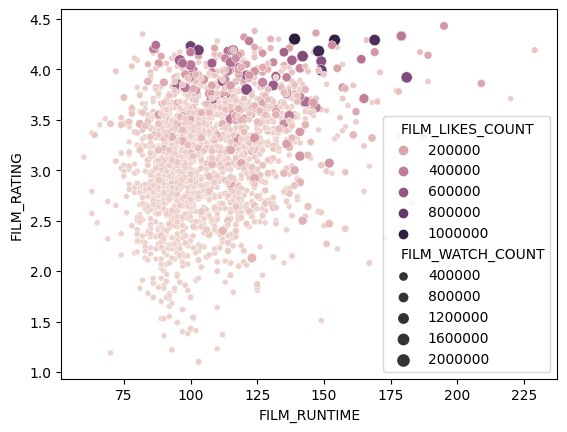

In [107]:
sns.scatterplot(data=df, x='FILM_RUNTIME', y='FILM_RATING', size='FILM_WATCH_COUNT', hue='FILM_LIKES_COUNT')

<Axes: xlabel='SCORE_BASIC', ylabel='SCORE_WEIGHTED'>

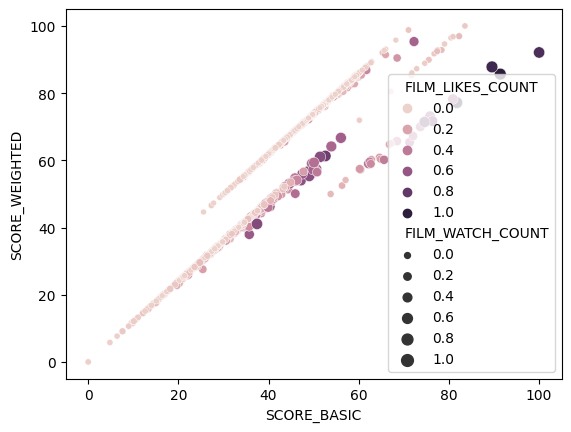

In [108]:
sns.scatterplot(data=df_scaled, x='SCORE_BASIC', y='SCORE_WEIGHTED', size='FILM_WATCH_COUNT', hue='FILM_LIKES_COUNT')

<Axes: xlabel='SCORE_WEIGHTED', ylabel='FILM_LIKES_COUNT'>

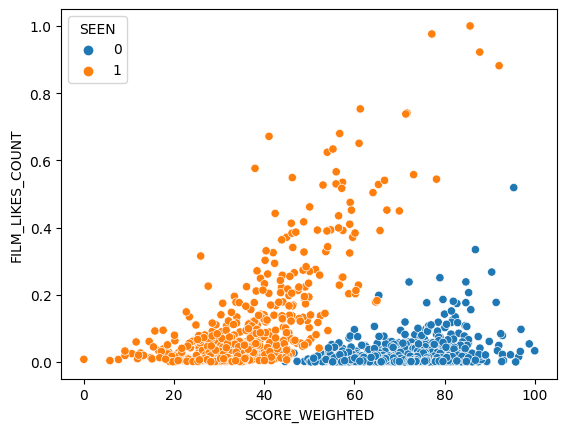

In [111]:
sns.scatterplot(data=df_scaled, x='SCORE_WEIGHTED', y='FILM_LIKES_COUNT', hue='SEEN')

<Axes: xlabel='FILM_RUNTIME', ylabel='FILM_WATCH_COUNT'>

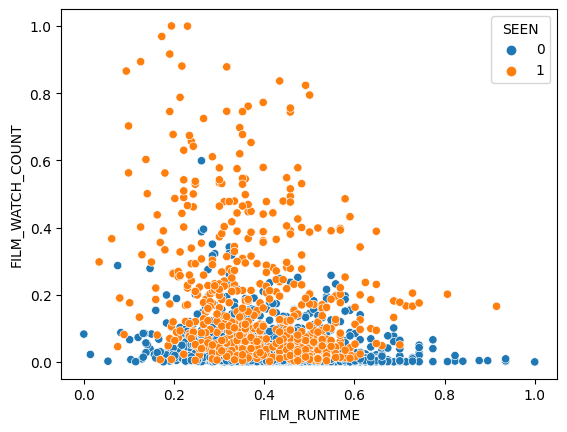

In [112]:
sns.scatterplot(data=df_scaled, x='FILM_RUNTIME', y='FILM_WATCH_COUNT', hue='SEEN')

In [120]:
df_scaled.sort_values('FILM_WATCH_COUNT', ascending=False).head(20)

,FILM_ID,FILM_TITLE,SEEN,FILM_WATCH_COUNT,FILM_TOP_250,FILM_RATING,FILM_LIKES_COUNT,FILM_FAN_COUNT,STREAMING,FILM_RUNTIME,FILM_GENRE,GENRE_SCORE,SEEN_SCORE,SCORE_BASIC,SCORE_WEIGHTED
1453,f_01skk,Inception,1,1.000000,1,0.924925,0.922156,0.408345,Yes,0.194307,science-fiction,1.000000,0,89.547126,87.804339
1441,f_02a9q,Fight Club,1,0.999376,1,0.960961,1.000000,0.720804,Yes,0.229875,drama,0.695815,0,91.387903,85.659895
1435,f_029Pq,Pulp Fiction,1,0.968674,1,0.957958,0.976009,0.500840,Yes,0.172904,crime,0.591790,0,81.756798,77.171814
1476,f_09vEe,Avengers: Infinity War,1,0.916343,0,0.867868,0.753082,0.129128,Yes,0.190620,adventure,0.832756,0,52.597351,61.303582
1468,f_04VZ8,Interstellar,1,0.893618,1,0.957958,0.881585,1.000000,Yes,0.126046,science-fiction,1.000000,0,100.000000,92.100658
1897,f_00728,Forrest Gump,1,0.880540,0,0.909910,0.671426,0.276072,Yes,0.217518,romance,0.000000,0,37.438123,41.073986
1477,f_03VH2,Guardians of the Galaxy,1,0.878163,0,0.810811,0.650736,0.048302,Yes,0.316886,adventure,0.832756,0,51.440721,61.042130
1473,f_09vE4,Avengers: Endgame,1,0.865689,0,0.846847,0.679721,0.138328,Yes,0.094151,adventure,0.832756,0,48.905660,56.747435
1481,f_018U8,The Truman Show,1,0.836148,1,0.927928,0.737849,0.298322,Yes,0.434308,comedy,0.387290,0,74.599146,71.407509
1494,f_01OEc,Up,1,0.823194,0,0.897898,0.540433,0.039348,Yes,0.491864,adventure,0.832756,0,56.042842,66.686869


In [119]:
df.sort_values('FILM_WATCH_COUNT', ascending=False).head(20)

,FILM_ID,FILM_TITLE,SEEN,FILM_WATCH_COUNT,FILM_TOP_250,FILM_RATING,FILM_LIKES_COUNT,FILM_FAN_COUNT,STREAMING,FILM_RUNTIME,FILM_GENRE,GENRE_SCORE
1453,f_01skk,Inception,1,2292605,225.0,4.18,926654,39861,Yes,148,science-fiction,0.054542
1441,f_02a9q,Fight Club,1,2291174,77.0,4.30,1004878,70362,Yes,139,drama,0.010263
1435,f_029Pq,Pulp Fiction,1,2220788,89.0,4.29,980770,48890,Yes,154,crime,-0.004879
1476,f_09vEe,Avengers: Infinity War,1,2100814,NaN,3.99,756756,12605,Yes,149,adventure,0.030197
1468,f_04VZ8,Interstellar,1,2048714,88.0,4.29,885885,97616,Yes,169,science-fiction,0.054542
1897,f_00728,Forrest Gump,1,2018733,NaN,4.13,674702,26949,Yes,142,romance,-0.091023
1477,f_03VH2,Guardians of the Galaxy,1,2013282,NaN,3.80,653911,4715,Yes,121,adventure,0.030197
1473,f_09vE4,Avengers: Endgame,1,1984684,NaN,3.92,683037,13503,Yes,181,adventure,0.030197
1481,f_018U8,The Truman Show,1,1916959,194.0,4.19,741448,29121,Yes,103,comedy,-0.034647
1494,f_01OEc,Up,1,1887261,NaN,4.09,543070,3841,Yes,96,adventure,0.030197


<Axes: xlabel='FILM_RATING', ylabel='FILM_FAN_COUNT'>

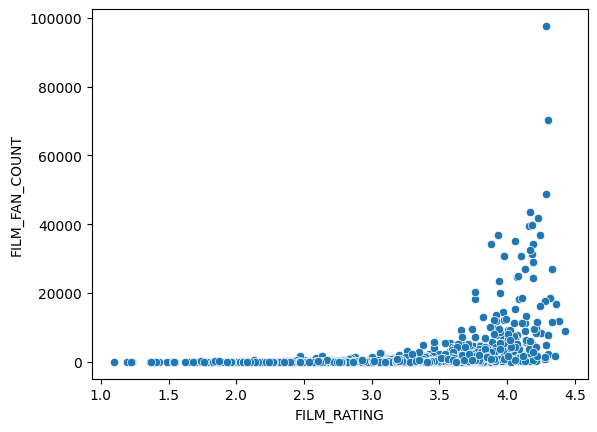

In [98]:
sns.scatterplot(data=df, x='FILM_RATING', y='FILM_FAN_COUNT')

<Axes: xlabel='FILM_WATCH_COUNT', ylabel='Count'>

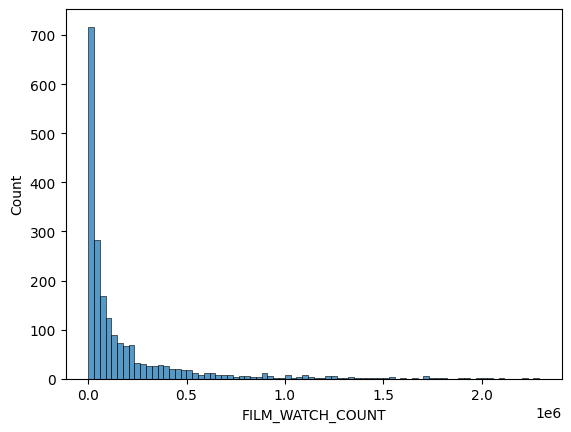

In [79]:
sns.histplot(df['FILM_WATCH_COUNT'])

In [4]:
rating_query = """

SELECT

	 a.FILM_ID
	,c.FILM_TITLE
	,d.FILM_GENRE
	,e.FILM_RATING
	,f.FILM_RATING_SCALED
	,f.FILM_RATING_SCALED - e.FILM_RATING AS RATING_VAR
	,ABS(f.FILM_RATING_SCALED - e.FILM_RATING) AS RATING_ABS_VAR

FROM ALL_FILMS a
LEFT JOIN CONTENT_TYPE b
ON a.FILM_ID = b.FILM_ID
LEFT JOIN FILM_TITLE c
ON a.FILM_ID = c.FILM_ID
LEFT JOIN FILM_GENRE d
ON a.FILM_ID = d.FILM_ID
LEFT JOIN FILM_LETTERBOXD_STATS e
ON a.FILM_ID = e.FILM_ID
LEFT JOIN PERSONAL_RATING f
ON a.FILM_ID = f.FILM_ID

WHERE CONTENT_TYPE = 'movie'
AND f.FILM_RATING_SCALED IS NOT NULL

ORDER BY RATING_VAR DESC
"""
rating_df = select_statement_to_df(rating_query)
rating_df

,FILM_ID,FILM_TITLE,FILM_GENRE,FILM_RATING,FILM_RATING_SCALED,RATING_VAR,RATING_ABS_VAR
0,f_027Vc,Star Wars: Episode I - The Phantom Menace,action,2.82,4.844595,2.024595,2.024595
1,f_01TM6,Jason X,science-fiction,2.21,4.174000,1.964000,1.964000
2,f_027V2,Star Wars: Episode II - Attack of the Clones,action,2.73,4.668919,1.938919,1.938919
3,f_0fBkw,The Nun,thriller,2.18,4.038000,1.858000,1.858000
4,f_0cY7Y,Godzilla: King of the Monsters,science-fiction,2.82,4.601351,1.781351,1.781351
...,...,...,...,...,...,...,...
747,f_01Yye,You've Got Mail,romance,3.44,1.314516,-2.125484,2.125484
748,f_0gnfO,Mamma Mia! Here We Go Again,romance,3.52,1.379032,-2.140968,2.140968
749,f_01QWs,Adulthood,drama,3.04,0.858696,-2.181304,2.181304
750,f_09n98,Me Before You,drama,3.40,1.097826,-2.302174,2.302174


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


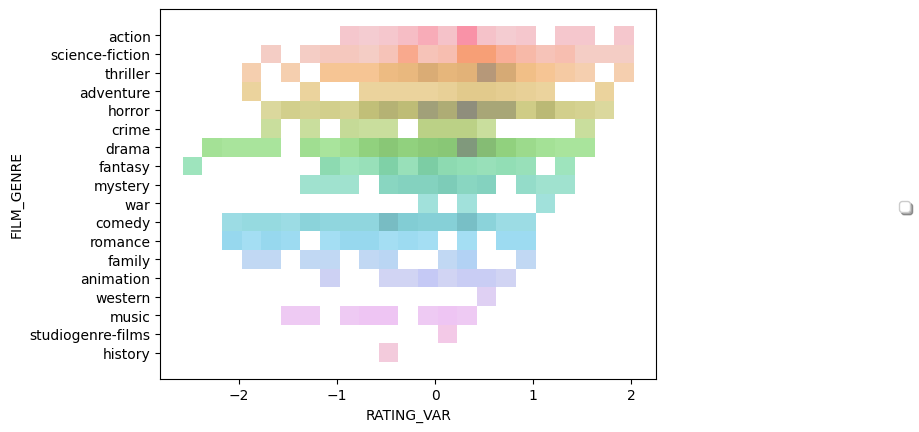

In [71]:
X_plot = np.linspace(0, 5, 100)
Y_plot = X_plot
sns.histplot(data=rating_df, x='RATING_VAR', y='FILM_GENRE', hue='FILM_GENRE', alpha=.66)
# plt.plot(X_plot, Y_plot, color='black', alpha=0.66)
plt.legend(loc='upper center', bbox_to_anchor=(1.5, 0.5), ncol=3, fancybox=True, shadow=True)

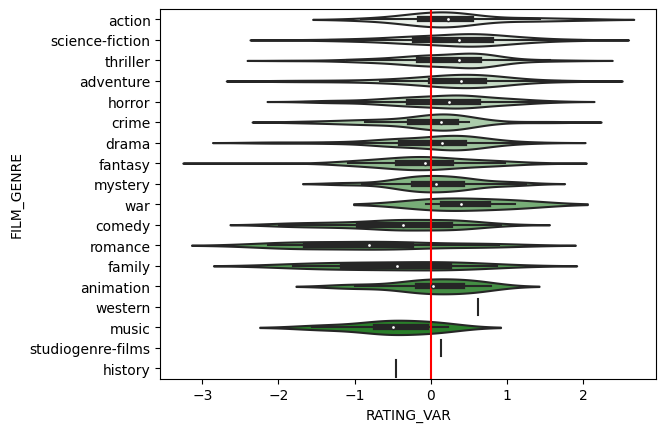

In [80]:
sns.violinplot(data=rating_df, x='RATING_VAR', y='FILM_GENRE', palette="light:g", orient="h")
plt.axvline(0, c='red')

In [19]:
rating_df_genre = rating_df.groupby('FILM_GENRE').agg({'FILM_RATING':'mean', 'FILM_RATING_SCALED':'mean', 'FILM_ID':'count'}).reset_index()
rating_df_genre

,FILM_GENRE,FILM_RATING,FILM_RATING_SCALED,FILM_ID
0,action,3.227857,3.518497,42
1,adventure,3.319565,3.563539,23
2,animation,3.692500,3.704565,16
3,comedy,3.373718,2.957717,78
4,crime,3.369130,3.310380,23
5,drama,3.651981,3.648703,106
6,family,3.151667,2.678337,12
7,fantasy,3.259500,3.140582,40
8,history,3.430000,2.978659,1
9,horror,3.074817,3.229155,164


5

C:\Users\tomdevine\AppData\Local\Temp\ipykernel_13672\3765123099.py:5: UserWarning: 
The palette list has fewer values (12) than needed (18) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data=rating_df_genre, x='FILM_RATING', y='FILM_RATING_SCALED', hue='FILM_GENRE', size='FILM_ID', alpha=.66, sizes=(10, 500), palette=sns.color_palette("Paired"))


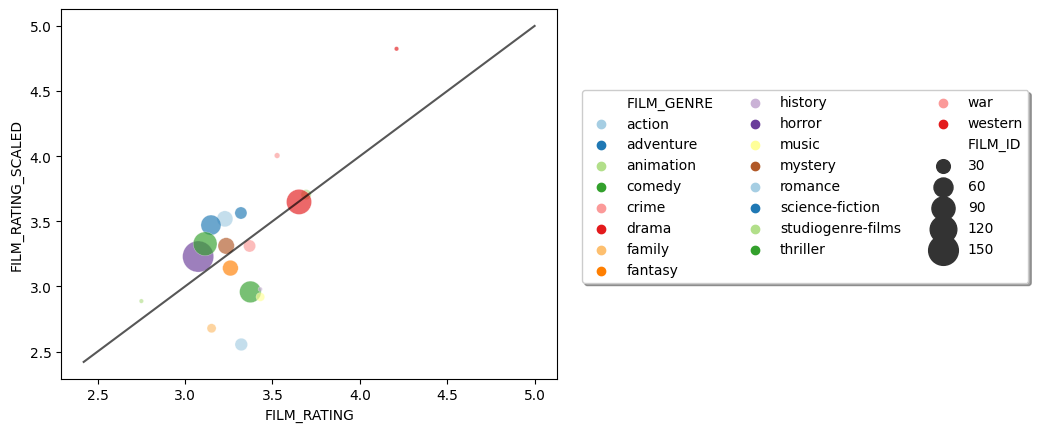

In [59]:
rating_min = int(100 * rating_df_genre[['FILM_RATING', 'FILM_RATING_SCALED']].min().min() * 0.95)/100
rating_max = min(int(100 * rating_df_genre[['FILM_RATING', 'FILM_RATING_SCALED']].max().max() * 1.05)/100, 5)
X_plot = np.linspace(rating_min, rating_max, 100)
Y_plot = X_plot
sns.scatterplot(data=rating_df_genre, x='FILM_RATING', y='FILM_RATING_SCALED', hue='FILM_GENRE', size='FILM_ID', alpha=.66, sizes=(10, 500), palette=sns.color_palette("Paired"))
plt.plot(X_plot, Y_plot, color='black', alpha=0.66)
plt.legend(loc='upper center', bbox_to_anchor=(1.5, 0.8), ncol=3, fancybox=True, shadow=True)